# LangGraph Basics

## Principle
1. State should use Immutable Pydantic, Do not use Mutable TypedDict.

## Node
1. Node is executable.
2. Nodes return Dictionaries (Updates to the state).
3. In ```A -> [B, C, D] -> E```, ```[B, C, D]``` is an ATOMIC/Transactional Superstep to run in parallel wherever possible. At each step, Delatas to State (check-point) is saved to the persistent memory. LangGraph retry if oen of the Superstep nodes fails, with ```RetryPolicy``` set.

## Edge

1. Edges (Routers) return Strings (The path to take).
2. **Static Edge** ```A -> B``` always run node ```B``` even when A fails or goes to ```END```. Use **Conditional Edge** ```(A ~> [B, END))``` not to run B when ```A->END```.
3. ```(A -> [B, C, D]``` is **AND**. After A, all nodes (B, C, D) run. Use Conditional Edge for ```A -> (B OR C)```.

In [1]:
import math
import time
from typing import (
    Any, 
    Dict, 
    Literal,
    Self,     # Pyton 3.11
    Optional,
)
from pydantic import (
    BaseModel,
    Field,
    ConfigDict,
    model_validator,
    field_validator,
)
from langgraph.graph import (
    StateGraph, 
    START, 
    END,
)
from langgraph.checkpoint.memory import (
    MemorySaver
)
from langgraph.types import RetryPolicy
from IPython.display import Image, display

In [2]:
%%html
<style>
table {float:left}
</style>

# Calculator Applicaiton

1. Router node get the ```+``` or ```-``` operator and operands (left/right). If unknown operator is given, stop there.
2. Router conditionally route to ```adder``` for '+' OR ```subtractor``` for '-'.
3. Router also route to ```evaluator``` to validate the expression of the same operation given, **only if** the operator is correct.
4. When ```adder``` (or ```subtractor```) result matches with the ```validator```, print the result. Otherwise ```inf``` to mark failure.

The ```evaluator``` fails (throw an error) first time. This is to test the LangGraph Superstep and Retry.

In [3]:
class State(BaseModel):
    """Immutable calculator application state.
    """
    # --------------------------------------------------------------------------------
    # Make the state Immutable. LangGraph Reducer is like Git commit creating a 
    # new copy of the state by updating with the delta. This is why the node
    # should only return the delta only.
    # --------------------------------------------------------------------------------
    model_config = ConfigDict(frozen=True)

    # --------------------------------------------------------------------------------
    # Initialize with sentinel to be able to catch uninitialised instance.
    # --------------------------------------------------------------------------------
    operator: str = Field(default="UNSET")
    left: float = Field(default=math.inf)
    right: float = Field(default=math.inf)
    result: float = Field(default=math.inf)
    validation: str = Field(default="UNSET")   # Validation expression to evaluate
    expected: float = Field(default=math.inf)   # validation expression evaluation result

    # --------------------------------------------------------------------------------
    # @model_validator(mode="after") tells Pydantic to validate the entire model after
    # values are set/checked. This allows to check the fully formed object (using self).
    # --------------------------------------------------------------------------------
    @model_validator(mode="after")
    def check_initialization(self) -> Self:
        """Strictly validates state integrity.
        
        Raises:
            ValueError: If operands are infinity or operator is unset.
        """
        # 1. Check Operator
        if self.operator == "UNSET":
            raise ValueError("Operator must be explicitly set to '+' or '-'.")

        # 2. Check Operands (The Sentinel Value check)
        if math.isinf(self.left) or math.isinf(self.right):
            raise ValueError(
                f"Operands must be real numbers. Got left={self.left}, right={self.right}"
            )

        # 2. Check Validation expression
        if self.validation == "UNSET":
            raise ValueError("Validation must be set to an expression e.g. '1+1' to validate the operation.")


        return self

In [4]:
class CalculatorGraph:
    """A service class containing logic for calculator graph nodes and routing."""
    def __init__(self, id: Optional[str] = None, prefix: str = "---"):
        self._prefix = prefix
        self._id = ''.join(random.choices(string.ascii_letters + string.digits, k=8)) if not id else id

        # --------------------------------------------------------------------------------
        # Build application graph
        # --------------------------------------------------------------------------------
        self._graph = StateGraph(State)

        self._graph.add_node(node="router", action=lambda state:state)
        self._graph.add_node(node="adder", action=self._add)
        self._graph.add_node(node="subtractor", action=self._subtract)
        # --------------------------------------------------------------------------------
        # To test the Superstep failure recovery/retry, use flag to make the Evaluator
        # fail, to see LangGraph will retry. See RetryPolicy added to the Evaluator node.
        # --------------------------------------------------------------------------------
        self._is_first_evaluation: bool = True
        self._graph.add_node(
            node="evaluator", action=self._evaluate_validation_expression,
            # Add retry logic to test the Superstep retry.
            # First time, raise RuntimeError and tell LangGraph to retry on it.
            # max_attempts = total allowed runs, so 2nd time will pass after retry.
            retry_policy=RetryPolicy(max_attempts=2, retry_on=RuntimeError)
        )
        self._graph.add_node(node="validator", action=self._validate)

        # --------------------------------------------------------------------------------
        # SuperStep - Rendezvous/Trnasaction mechanism
        # --------------------------------------------------------------------------------
        # 1. Fan-out: 
        # - A Superstep contains ALL nodes that run in parallel as an ATOMIC manner.
        # - The graph wait for all of them to complete and Checkpointer holds until the last
        #   running node in that Superstep finishes.
        # 2. Fan-in
        # - Merges deltas from the nodes and create a new State (NOTE update, Hence, immutable).
        #   (actually not the entire new state, but deltas only, like AWS EBS snapthot updates).
        # 3. Recovery
        # - If a node crashes, the graph rolls back to the start of the failed Superstep and 
        #   re-run from the last successful checkpoint.
        # 4. LIMITS:
        # - Recursion Limit: LangGraph defaults to 25 Supersteps (not 25 nodes) per invocation 
        #   to prevent infinite loops.
        # --------------------------------------------------------------------------------

        # Adding static edge to evaluator always run evaluator when router returns __end__.
        # If there is invalid operator give to the router, then the graph should stop.
        # However, the static route to from "router" -> "evaluator" make "evaluator" run.
        # self._graph.add_edge("router", "evaluator")
        self._graph.add_conditional_edges(
            source="router",    # The node where the split happens
            path=self._route,   # The function that decides the path
            path_map={          # The mapping of function output to graph nodes
                "addition_operation": "adder",
                "subtraction_operation": "subtractor",
                "evaluation_operation": "evaluator",     # <--- In place of graph.add_edge("router", "evaluator")
                "__end__": END
            }
        )
        # --------------------------------------------------------------------------------
        # graph.add_edge(["adder", "subtractor", "evaluator"], "validator") fails here.
        # Beause this is AND condition on ["adder", "subtractor", "evaluator"], meaning
        # all the nodes ["adder", "subtractor", "evaluator"] must run and completes.
        # However, the conditional path is ("adder" OR "subtractor") -> "validator".
        # --------------------------------------------------------------------------------
        # This fails.
        # self._graph.add_edge(["adder", "subtractor", "evaluator"], "validator")
        # --------------------------------------------------------------------------------

        # --------------------------------------------------------------------------------
        # Force validator to wait for BOTH the math (add OR sub) and the evaluation.
        # This is safe because both math and "evaluator" ARE guaranteed to run
        # --------------------------------------------------------------------------------
        # self._graph.add_edge("adder", "validator")
        # self._graph.add_edge("subtractor", "validator")
        # self._graph.add_edge("evaluator", "validator")
        self._graph.add_edge(["adder", "evaluator"], "validator") 
        self._graph.add_edge(["subtractor", "evaluator"], "validator")

        self._graph.set_entry_point("router")
        self._graph.set_finish_point("validator")

        # --------------------------------------------------------------------------------
        # Check Pointing. See SuperStep/Pregel.
        # --------------------------------------------------------------------------------
        # A checkpointer saves graph's state at a Super Step.
        #
        # 1. CORE RESPONSIBILITIES:
        #   - Persistence: Saves state to RAM or DB so workflows can resume after crashes.
        #   - Threading: Uses 'thread_id' to keep different user sessions isolated.
        #   - Time Travel: Saves snapshots after EVERY node, allowing you to rewind or replay.
        #
        # 2. HOW IT WORKS (WORKFLOW):
        #   - Lookup: Searches for a 'thread_id' in storage when invoked.
        #   - Resume: Loads the most recent snapshot if a history exists.
        #   - Snapshots: Automatically saves state 'deltas' as each node completes.
        #   - Finalize: Marks the terminal state as the 'current' version once END is reached.
        # --------------------------------------------------------------------------------
        # Initialize simple in-memory storage. Use a proper database for production.
        self._checkpointer = MemorySaver()
        
        # Compile graph with checkpointing enabled
        self._application = self._graph.compile(checkpointer=self._checkpointer)

    def _add(self, state: State) -> Dict[str, Any]:
        """Adds the two numbers in the state."""
        print(f"{self._prefix} Executing Adder {state.left}+{state.right} {self._prefix}")
        return {"result": state.left + state.right}

    def _subtract(self, state: State) -> Dict[str, Any]:
        """Subtracts right from left."""
        print(f"{self._prefix} Executing Subtractor {self._prefix}")
        return {"result": state.left - state.right}

    # def _route(
    #     self, state: State
    # ) -> Literal["addition_operation", "subtraction_operation", "__end__"]:
    #     """Routes to an operation based on the operator string."""
    #     match state.operator:
    #         case "+":
    #             print(f"{self._prefix} Routing to Adder {self._prefix}")
    #             return "addition_operation"
    #         case "-":
    #             print(f"{self._prefix} Routing to Subtractor {self._prefix}")
    #             return "subtraction_operation"
    #         case _:
    #             print(f"{self._prefix} Unknown operator:[{state.operator}] {self._prefix}")
    # 
    #     return "__end__"

    # 2. Update the routing logic to return both nodes (Parallel Return)
    def _route(
        self, state: State
    )-> Literal["addition_operation", "subtraction_operation", "evaluation_operation", "__end__"]:
        """Routes to an operation based on the operator string."""
        match state.operator:
            case "+":
                # Return a list to trigger both nodes in parallel
                print(f"{self._prefix} Routing to Adder and Evaluation {self._prefix}")
                return ["addition_operation", "evaluation_operation"]
            case "-":
                print(f"{self._prefix} Routing to Subtractor and Evaluation {self._prefix}")
                return ["subtraction_operation", "evaluation_operation"]
            case _:
                print(f"{self._prefix} Unknown operator:[{state.operator}] {self._prefix}")
                return "__end__"

            
    def _evaluate_validation_expression(self, state: State) -> Dict[str, Any]:
        """Evaluate the validation expression"""
        print(f"{self._prefix} Evaluationg expression [{state.validation}] {self._prefix}")
        if self._is_first_evaluation:
            self._is_first_evaluation = False
            print("raise RuntimeError to test LangGraph retry")
            raise RuntimeError("Evaluator intentionally failed to test Superstep retry") 

        print("Retry of Evaluator")
        time.sleep(3)
        return {"expected": eval(state.validation)}
        
    def _validate(self, state: State) -> Dict[str, Any]:
        """Validate the result with the expression result"""
        print(f"{self._prefix} Validating expected:[{state.expected}] & actual:[{state.result}] {self._prefix}")
        if not state.result == state.expected:
            print(f"Incorrect result:[{state.result}] != eval({state.validation})")
            return {"result": math.inf}

        print("validation success")
        return {}
        
    def is_number(self, value):
        return isinstance(value, (int, float))
    
    def display(self):
        display(Image(self._application.get_graph().draw_mermaid_png()))
        
    def __enter__(self):
        """Context manager 'with' statement"""
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """
        Deterministic/guaranteed to be triggered at the Context Manager 'with' exit.
        """
        pass

    def __del__(self):
        """Non-Deterministic way as triggered by Python's Garbage Collector."""
        pass

    def __call__(
        self, 
        operator: str = "UNSET", 
        left: float = math.inf, 
        right: float = math.inf, 
        validation: str = "UNSET",
        config: Optional[Dict[str, Any]] = None
    ):
        """Runs the graph application.
        Args:
            operator: '+' or '-'
            left: left operand number
            right: right operand number
            validation: validation string, same with the operation
            config: StateGraph configuration dictionary

        Returns: operation result
        """
        config: Dict[str, Any] = {"configurable": {"thread_id": self._id}} if not config else config
        # reference.langchain.com/python/langgraph/graphs/#langgraph.graph.state.CompiledStateGraph.invoke
        # invoke() returns dictionary.
        result: Dict[str, Any] = self._application.invoke(
            input=State(operator=operator, left=left, right=right, validation=validation), config=config
        )
        answer: float = result.get('result')
        assert self.is_number(answer)
        return answer

# Execution

LangGraph operates on a Synchronous Superstep model (Pregel). Here is the execution flow of the graph:

1. Superstep 1: The router executes. It calculates the next moves.
2. Superstep 2 (Parallel Fan-out):
   * The evaluator starts.
   * The adder (or subtractor) starts. The Constraint: LangGraph will not move to the next Superstep until every active node in this layer has either finished successfully or been skipped.The Retry Factor: If the evaluator fails and retries, Superstep 2 is effectively "extended." The graph engine will wait for the evaluator to complete its retry attempts before it ever looks at the edges leading to the validator.  <br>
3. Superstep 3: Only after evaluator and adder have both written their results to the State, the validator is triggered.

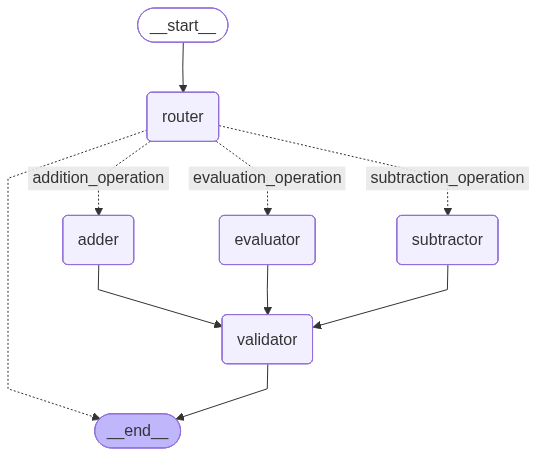

--- Routing to Adder and Evaluation ---
--- Executing Adder 1.0+1.01 ---
--- Evaluationg expression [1.0 + 1.01] ---
raise RuntimeError to test LangGraph retry
--- Evaluationg expression [1.0 + 1.01] ---
Retry execution of the Evaluator
--- Validating expected:[2.01] & actual:[2.01] ---
validation success
2.01


In [17]:
with CalculatorGraph(id="1") as calc:
    calc.display()
    print(calc(operator='+', left=1.0, right=1.01, validation="1.0 + 1.01"))

---
# Asynchronous Version


| Synchronous           | Asynchronous Equivalent                |
|-----------------------|----------------------------------------|
| def node_name(state): | async def node_name(state):            |
| time.sleep(seconds)   | await asyncio.sleep(seconds)           |
| app.invoke(input)     | await app.ainvoke(input)               |
| app.stream(input)     | async for chunk in app.astream(input): |

In [6]:
import asyncio
import random
import string

In [12]:
class AsyncCalculatorGraph:
    """A service class containing logic for calculator graph nodes and routing."""
    def __init__(self, id: Optional[str] = None, prefix: str = "---"):
        self._prefix = prefix
        self._id = ''.join(random.choices(string.ascii_letters + string.digits, k=8)) if not id else id

        # --------------------------------------------------------------------------------
        # Build application graph
        # --------------------------------------------------------------------------------
        self._graph = StateGraph(State)

        self._graph.add_node(node="router", action=lambda state:state)
        self._graph.add_node(node="adder", action=self._add)
        self._graph.add_node(node="subtractor", action=self._subtract)
        # --------------------------------------------------------------------------------
        # To test the Superstep failure recovery/retry, use flag to make the Evaluator
        # fail, to see LangGraph will retry. See RetryPolicy added to the Evaluator node.
        # --------------------------------------------------------------------------------
        self._is_first_evaluation: bool = True
        self._graph.add_node(
            node="evaluator", action=self._evaluate_validation_expression,
            # Add retry logic to test the Superstep retry.
            # First time, raise RuntimeError and tell LangGraph to retry on it.
            # max_attempts = total allowed runs, so 2nd time will pass after retry.
            retry_policy=RetryPolicy(max_attempts=2, retry_on=RuntimeError)
        )
        self._graph.add_node(node="validator", action=self._validate)

        # --------------------------------------------------------------------------------
        # SuperStep - Rendezvous/Trnasaction mechanism
        # --------------------------------------------------------------------------------
        # 1. Fan-out: 
        # - A Superstep contains ALL nodes that run in parallel as an ATOMIC manner.
        # - The graph wait for all of them to complete and Checkpointer holds until the last
        #   running node in that Superstep finishes.
        # 2. Fan-in
        # - Merges deltas from the nodes and create a new State (NOTE update, Hence, immutable).
        #   (actually not the entire new state, but deltas only, like AWS EBS snapthot updates).
        # 3. Recovery
        # - If a node crashes, the graph rolls back to the start of the failed Superstep and 
        #   re-run from the last successful checkpoint.
        # 4. LIMITS:
        # - Recursion Limit: LangGraph defaults to 25 Supersteps (not 25 nodes) per invocation 
        #   to prevent infinite loops.
        # --------------------------------------------------------------------------------
        self._graph.add_conditional_edges(
            source="router",
            path=self._route,
            path_map={
                "addition_operation": "adder",
                "subtraction_operation": "subtractor",
                "evaluation_operation": "evaluator",
                "__end__": END
            }
        )
        # --------------------------------------------------------------------------------
        # graph.add_edge(["adder", "subtractor", "evaluator"], "validator") fails here.
        # Beause this is AND condition on ["adder", "subtractor", "evaluator"], meaning
        # all the nodes ["adder", "subtractor", "evaluator"] must run and completes.
        # However, the conditional path is ("adder" OR "subtractor") -> "validator".
        # --------------------------------------------------------------------------------
        # This fails.
        # self._graph.add_edge(["adder", "subtractor", "evaluator"], "validator")
        # --------------------------------------------------------------------------------

        # --------------------------------------------------------------------------------
        # Force validator to wait for BOTH the math (add OR sub) and the evaluation.
        # This is safe because both math and "evaluator" ARE guaranteed to run
        # --------------------------------------------------------------------------------
        # self._graph.add_edge("adder", "validator")
        # self._graph.add_edge("subtractor", "validator")
        # self._graph.add_edge("evaluator", "validator")
        self._graph.add_edge(["adder", "evaluator"], "validator") 
        self._graph.add_edge(["subtractor", "evaluator"], "validator")

        self._graph.set_entry_point("router")
        self._graph.set_finish_point("validator")

        # --------------------------------------------------------------------------------
        # Check Pointing. See SuperStep/Pregel.
        # --------------------------------------------------------------------------------
        # A checkpointer saves graph's state at a Super Step.
        #
        # 1. CORE RESPONSIBILITIES:
        #   - Persistence: Saves state to RAM or DB so workflows can resume after crashes.
        #   - Threading: Uses 'thread_id' to keep different user sessions isolated.
        #   - Time Travel: Saves snapshots after EVERY node, allowing you to rewind or replay.
        #
        # 2. HOW IT WORKS (WORKFLOW):
        #   - Lookup: Searches for a 'thread_id' in storage when invoked.
        #   - Resume: Loads the most recent snapshot if a history exists.
        #   - Snapshots: Automatically saves state 'deltas' as each node completes.
        #   - Finalize: Marks the terminal state as the 'current' version once END is reached.
        # --------------------------------------------------------------------------------
        # Initialize simple in-memory storage. Use a proper database for production.
        self._checkpointer = MemorySaver()
        
        # Compile graph with checkpointing enabled
        self._application = self._graph.compile(checkpointer=self._checkpointer)

    async def _add(self, state: State) -> Dict[str, Any]:
        """Adds the two numbers in the state."""
        print(f"{self._prefix} Executing Adder {state.left}+{state.right} {self._prefix}")
        return {"result": state.left + state.right}

    async def _subtract(self, state: State) -> Dict[str, Any]:
        """Subtracts right from left."""
        print(f"{self._prefix} Executing Subtractor {self._prefix}")
        return {"result": state.left - state.right}

    async def _route(
        self, state: State
    )-> Literal["addition_operation", "subtraction_operation", "evaluation_operation", "__end__"]:
        """Routes to an operation based on the operator string."""
        match state.operator:
            case "+":
                # Return a list to trigger both nodes in parallel
                print(f"{self._prefix} Routing to Adder and Evaluation {self._prefix}")
                return ["addition_operation", "evaluation_operation"]
            case "-":
                print(f"{self._prefix} Routing to Subtractor and Evaluation {self._prefix}")
                return ["subtraction_operation", "evaluation_operation"]
            case _:
                print(f"{self._prefix} Unknown operator:[{state.operator}] {self._prefix}")
                return "__end__"

    async def _evaluate_validation_expression(self, state: State) -> Dict[str, Any]:
        """Evaluate the validation expression"""
        print(f"{self._prefix} Evaluationg expression [{state.validation}] {self._prefix}")
        if self._is_first_evaluation:
            self._is_first_evaluation = False
            print("raise RuntimeError to test LangGraph retry")
            raise RuntimeError("Evaluator intentionally failed to test Superstep retry") 

        print("Retry of Evaluator")
        await asyncio.sleep(2) # Non-blocking sleep
        return {"expected": eval(state.validation)}
        
    async def _validate(self, state: State) -> Dict[str, Any]:
        """Validate the result with the expression result"""
        print(f"{self._prefix} Validating expected:[{state.expected}] & actual:[{state.result}] {self._prefix}")
        if not state.result == state.expected:
            print(f"Incorrect result:[{state.result}] != eval({state.validation})")
            return {"result": math.inf}

        print("validation success")
        return {}
        
    def is_number(self, value):
        return isinstance(value, (int, float))
    
    def display(self):
        display(Image(self._application.get_graph().draw_mermaid_png()))
        
    async def __aenter__(self):
        """Context manager 'with' statement"""
        return self

    async def __aexit__(self, exc_type, exc_val, exc_tb):
        """
        Deterministic/guaranteed to be triggered at the Context Manager 'with' exit.
        """
        pass

    def __del__(self):
        """Non-Deterministic way as triggered by Python's Garbage Collector."""
        pass

    async def __call__(
        self, 
        operator: str = "UNSET", 
        left: float = math.inf, 
        right: float = math.inf, 
        validation: str = "UNSET",
        config: Optional[Dict[str, Any]] = None
    ):
        """Runs the graph application.
        Args:
            operator: '+' or '-'
            left: left operand number
            right: right operand number
            validation: validation string, same with the operation
            config: StateGraph configuration dictionary

        Returns: operation result
        """
        config: Dict[str, Any] = {"configurable": {"thread_id": self._id}} if not config else config

        # Use ainvoke for asynchronous execution
        result: Dict[str, Any] = await self._application.ainvoke(
            input=State(operator=operator, left=left, right=right, validation=validation), config=config
        )
        answer: float = result.get('result')
        assert self.is_number(answer)
        return answer

## Execution
###  Failure case as validation expression does not match with the operation

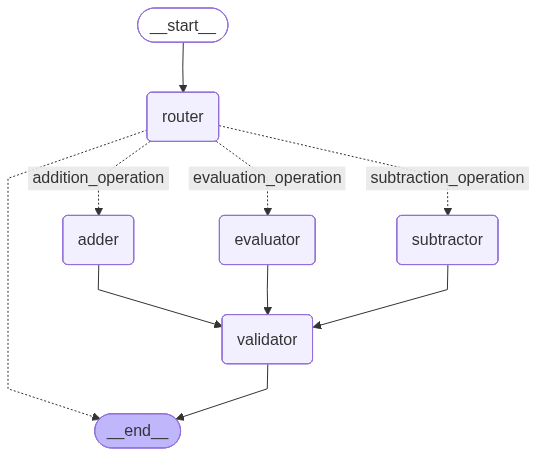

--- Routing to Subtractor and Evaluation ---
--- Evaluationg expression [10.5 + 4.5] ---
raise RuntimeError to test LangGraph retry
--- Executing Subtractor ---
--- Evaluationg expression [10.5 + 4.5] ---
Retry execution of the Evaluator
--- Validating expected:[15.0] & actual:[6.0] ---
Incorrect result:[6.0] != eval(10.5 + 4.5)
Final Result: inf


In [16]:
async def run_example():
    async with AsyncCalculatorGraph() as calc:
        calc.display()
        result = await calc(operator="-", left=10.5, right=4.5, validation="10.5 + 4.5")
        print(f"Final Result: {result}")

await run_example()

## Success case

In [15]:
async def run_example():
    async with AsyncCalculatorGraph() as calc:
        result = await calc(operator="-", left=10.5, right=4.5, validation="10.5 - 4.5")
        print(f"Final Result: {result}")

await run_example()

--- Routing to Subtractor and Evaluation ---
--- Evaluationg expression [10.5 - 4.5] ---
raise RuntimeError to test LangGraph retry
--- Executing Subtractor ---
--- Evaluationg expression [10.5 - 4.5] ---
Retry execution of the Evaluator
--- Validating expected:[6.0] & actual:[6.0] ---
validation success
Final Result: 6.0
